In [1]:
import tensorboard as tb
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from packaging import version
from scipy import stats
from scipy.interpolate import Rbf


major_ver, minor_ver, _ = version.parse(tb.__version__).release
assert major_ver >= 2 and minor_ver >= 3, \
    "This notebook requires TensorBoard 2.3 or later."
print("TensorBoard version: ", tb.__version__)

TensorBoard version:  2.3.0


In [15]:
# # for CartPole
# experiment_ids = ["N6T4MvXPQRCEvamXGNS7Mg", "X1A72SjrSkWeaCKefMbtOA"]

# for Halfcheetah
experiment_ids = ["ehAu5EPfRMeEQgvt1FBMHQ", "k3lpEqjNRvq03BHWylhpQQ"]#"OmdcLY61TMOQPvYmcKcEOw"]

experiments = []
# dfs = []
for experiment_id in experiment_ids:
    experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
    experiments.append(experiment)
#     dfs.append(experiment.get_scalars())

# Train or Validate?

In [16]:
dfws = []
for experiment in experiments:
    dfw = experiment.get_scalars(pivot=False)
    dfw = dfw[dfw.tag.str.startswith("validate/total")]
    dfws.append(dfw)

In [17]:
len(dfws)

2

In [18]:
old_dfws = dfw.copy()

In [19]:
dfws = [dfws[1][dfws[1].run.str.contains('ZG')], dfws[1][dfws[1].run.str.contains('RF')], dfws[1][dfws[1].run.str.contains('RR')], dfws[0]]

In [20]:
ENV_NAMES = ['Zero Gradient', 'Reward Flipping', 'Random Reward']

In [21]:
dfws[-1].run.unique()

dfws[0] = pd.concat([dfws[0], dfws[-1][dfws[-1].run.str.contains('Ours_W10_') | dfws[-1].run.str.contains('Ours_W1_')]])
dfws[1] = pd.concat([dfws[1], dfws[-1][dfws[-1].run.str.contains('Ours_W10_') | dfws[-1].run.str.contains('Ours_W1_')]])
dfws[2] = pd.concat([dfws[2], dfws[-1][dfws[-1].run.str.contains('Ours_W10_') | dfws[-1].run.str.contains('Ours_W1_')]])
                     

In [22]:
dfws[0].run.unique()

array(['HalfCheetah-v2/worker10_byzantine3_zero-gradient/Exp7_HalfCheetah_Ours_W10B3_ZG_20210210T122531',
       'HalfCheetah-v2/worker10_byzantine0_detect-attack/Exp1_HalfCheetah2_Ours_W10_20210120T201248',
       'HalfCheetah-v2/worker1_byzantine0_detect-attack/Exp1_HalfCheetah2_Ours_W1_20210120T201241'],
      dtype=object)

# Plot configurations


In [23]:
# ################# for CartPole
# max_trajectories_ls = [int(5e3), int(5e3), int(5e3)]

################# for HalfCheetah
max_trajectories_ls = [int(1e4), int(1e4), int(1e4)]

max_runs = 6
interval = 0.90

# Plot!

['Exp1_HalfCheetah2_Ours_W1', 'Exp1_HalfCheetah2_Ours_W10', 'Exp7_HalfCheetah_Ours_W10B3_ZG']
['validate/total_rewards_0' 'validate/total_rewards_1'
 'validate/total_rewards_2' 'validate/total_rewards_3'
 'validate/total_rewards_4' 'validate/total_rewards_5'
 'validate/total_rewards_6' 'validate/total_rewards_7']
['Exp1_HalfCheetah2_Ours_W1', 'Exp1_HalfCheetah2_Ours_W10', 'Exp7_HalfCheetah_Ours_W10B3_RF']
['validate/total_rewards_0' 'validate/total_rewards_1'
 'validate/total_rewards_2' 'validate/total_rewards_3'
 'validate/total_rewards_4' 'validate/total_rewards_5'
 'validate/total_rewards_6' 'validate/total_rewards_7']
['Exp1_HalfCheetah2_Ours_W1', 'Exp1_HalfCheetah2_Ours_W10', 'Exp7_HalfCheetah_Ours_W10B3_RR']
['validate/total_rewards_0' 'validate/total_rewards_1'
 'validate/total_rewards_2' 'validate/total_rewards_3'
 'validate/total_rewards_4' 'validate/total_rewards_5'
 'validate/total_rewards_6' 'validate/total_rewards_7']


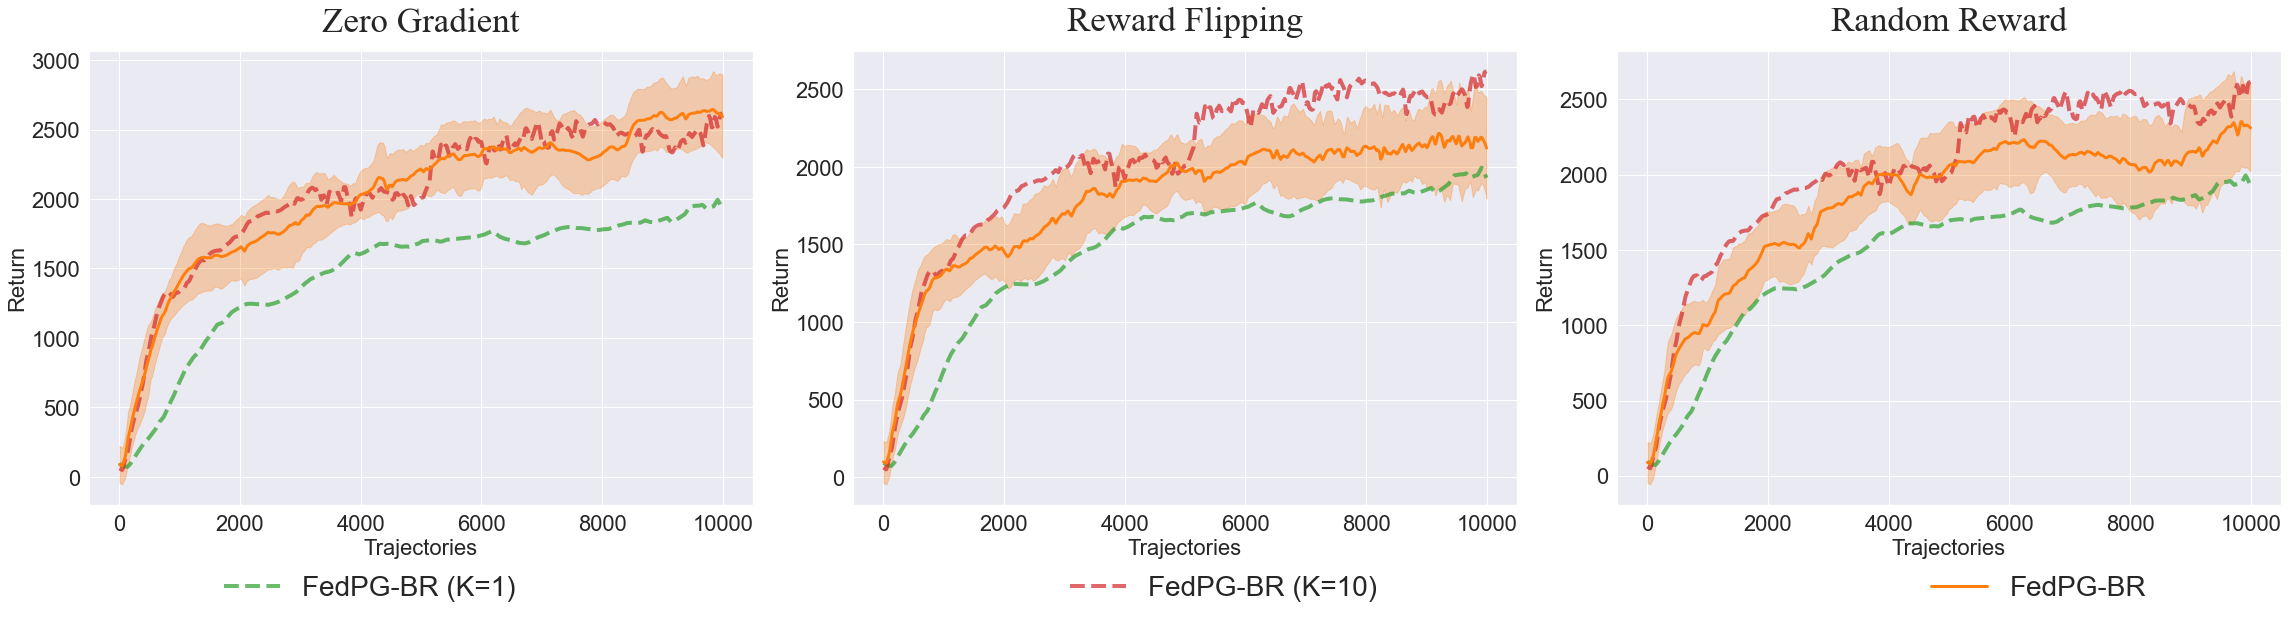

In [24]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 3, figsize=(32,8))
colors =  [u'#2ca02c', u'#d62728', u'#ff7f0e', u'#1f77b4', u'#d62728', u'#8c564b']
#colors = [ u'#1f77b4', u'#2ca02c', u'#d62728', u'#d62728', u'#8c564b']


for plot_id in range(3):

    
    dfw = dfws[plot_id]
    max_trajectories = max_trajectories_ls[plot_id]
    
    runs = dfw["run"].unique()
    runs_ordered = []
    runs_ordered_labels = []
    
    runs_name = []
    for name in runs:
        name = '_'.join((name.split('/')[-1].split('_')[:-1]))
        if not name in runs_name: runs_name.append(name)
    
    for i in range(10):
        for name in runs_name:

            if i == 9 and 'Ours' in name and 'W10B3' in name:
                runs_ordered.append(name)
                runs_ordered_labels.append('FedPG-BR')
            elif i == 1 and 'Ours' in name and ('_W10_' in name or name[-4:] == '_W10'):
                runs_ordered.append(name)
                runs_ordered_labels.append('FedPG-BR (K=10)')
            elif i == 0 and 'Ours' in name and name[-3:] == '_W1':
                runs_ordered.append(name)
                runs_ordered_labels.append('FedPG-BR (K=1)')
           
    print(runs_ordered)
    
    for idx, run_name in enumerate(runs_ordered):
        run_name += '_'
        if 'W10_' in run_name or 'FedPG-BR (K=1)' in runs_ordered_labels[idx]:
            cur_dfw = dfw[dfw.run.str.contains(f'{run_name}')]
            lines = []
            for run_id in range(max_runs):
                steps = cur_dfw[cur_dfw.tag.str.endswith(f'{run_id}')]['step'].to_numpy()
                values = cur_dfw[cur_dfw.tag.str.endswith(f'{run_id}')]['value'].to_numpy()
                lines.append(Rbf(steps, values, function = 'linear')(np.arange(max_trajectories)))
            
            mean = np.mean(lines, axis=0)
            axes[plot_id].plot(mean, label=(f"{runs_ordered_labels[idx]}"), linewidth=4., linestyle = 'dashed', alpha = 0.7, color = colors[idx])
            
            
        else:
            
            cur_dfw = dfw[dfw.run.str.contains(f'{run_name}')]
            lines = []
            print(cur_dfw.tag.unique())
            for run_id in cur_dfw.tag.unique():

                steps = cur_dfw[cur_dfw.tag.str.contains(f'{run_id}')]['step'].to_numpy()
                values = cur_dfw[cur_dfw.tag.str.contains(f'{run_id}')]['value'].to_numpy()
                if steps.size < 100:
                    continue
                else:
#                     print(run_name, run_id)
                    pass
                lines.append(Rbf(steps, values, function = 'linear')(np.arange(max_trajectories)))
            mean = np.mean(lines, axis=0)
            l, h = stats.norm.interval(interval, loc=np.mean(lines, axis = 0), scale=stats.sem(lines, axis = 0))
            axes[plot_id].plot(mean, label=(f"{runs_ordered_labels[idx]}"), linewidth=3, color = colors[idx])
            axes[plot_id].fill_between(range(int(max_trajectories)), l, h, alpha = 0.3, color = colors[idx])    


#         axes[plot_id].xlabel("Trajectories")
#         axes[plot_id].ylabel("Return")
        axes[plot_id].set_title(ENV_NAMES[plot_id], fontsize=35, 
                                pad=20,
                                fontname='Times New Roman')
        axes[plot_id].tick_params(labelsize=22)
        
        axes[plot_id].set_xlabel("Trajectories", fontsize=22)
        axes[plot_id].set_ylabel("Return", fontsize=22)
# ax.set_yticklabels(y_ticks, rotation=0, fontsize=8)
# plt.legend(loc='bottom', 
#            ncol=1, 
#            handlelength=1,
#            mode="expand", 
#            bbox_to_anchor=(1.05, 0, 1,0), borderaxespad=0, prop={'size': 13})
plt.tight_layout(pad=1)


# plt.rcParams["font.family"] = "Times New Roman"

# Shrink current axis's height by 10% on the bottom

length_ = (axes[2].get_position().x1 - axes[0].get_position().x0) / (axes[0].get_position().x1 - axes[0].get_position().x0)


# Put a legend below current axis
plt_lgd = plt.legend(loc='upper left', bbox_to_anchor=(length_ * 0.05, -0.1, length_ * 0.9, 0), bbox_transform=axes[0].transAxes,
         mode = "expand", fancybox=False, shadow=False, ncol=4, fontsize = 28, frameon=False)

plt.savefig('./new3attack_halfcheetah.pdf', format='pdf', dpi=600,
            bbox_extra_artists=(plt_lgd,), bbox_inches='tight')
plt.show()

['Exp1_HalfCheetah2_Ours_W1', 'Exp1_HalfCheetah2_Ours_W10', 'Exp7_HalfCheetah_Ours_W10B3_ZG']
['validate/total_rewards_0' 'validate/total_rewards_1'
 'validate/total_rewards_2' 'validate/total_rewards_3'
 'validate/total_rewards_4' 'validate/total_rewards_5'
 'validate/total_rewards_6' 'validate/total_rewards_7'
 'validate/total_rewards_8' 'validate/total_rewards_9']
['Exp1_HalfCheetah2_Ours_W1', 'Exp1_HalfCheetah2_Ours_W10', 'Exp7_HalfCheetah_Ours_W10B3_RF']
['validate/total_rewards_0' 'validate/total_rewards_1'
 'validate/total_rewards_2' 'validate/total_rewards_3'
 'validate/total_rewards_4' 'validate/total_rewards_5'
 'validate/total_rewards_6' 'validate/total_rewards_7'
 'validate/total_rewards_8' 'validate/total_rewards_9']
['Exp1_HalfCheetah2_Ours_W1', 'Exp1_HalfCheetah2_Ours_W10', 'Exp7_HalfCheetah_Ours_W10B3_RR']
['validate/total_rewards_0' 'validate/total_rewards_1'
 'validate/total_rewards_2' 'validate/total_rewards_3'
 'validate/total_rewards_4' 'validate/total_rewards_5'
 

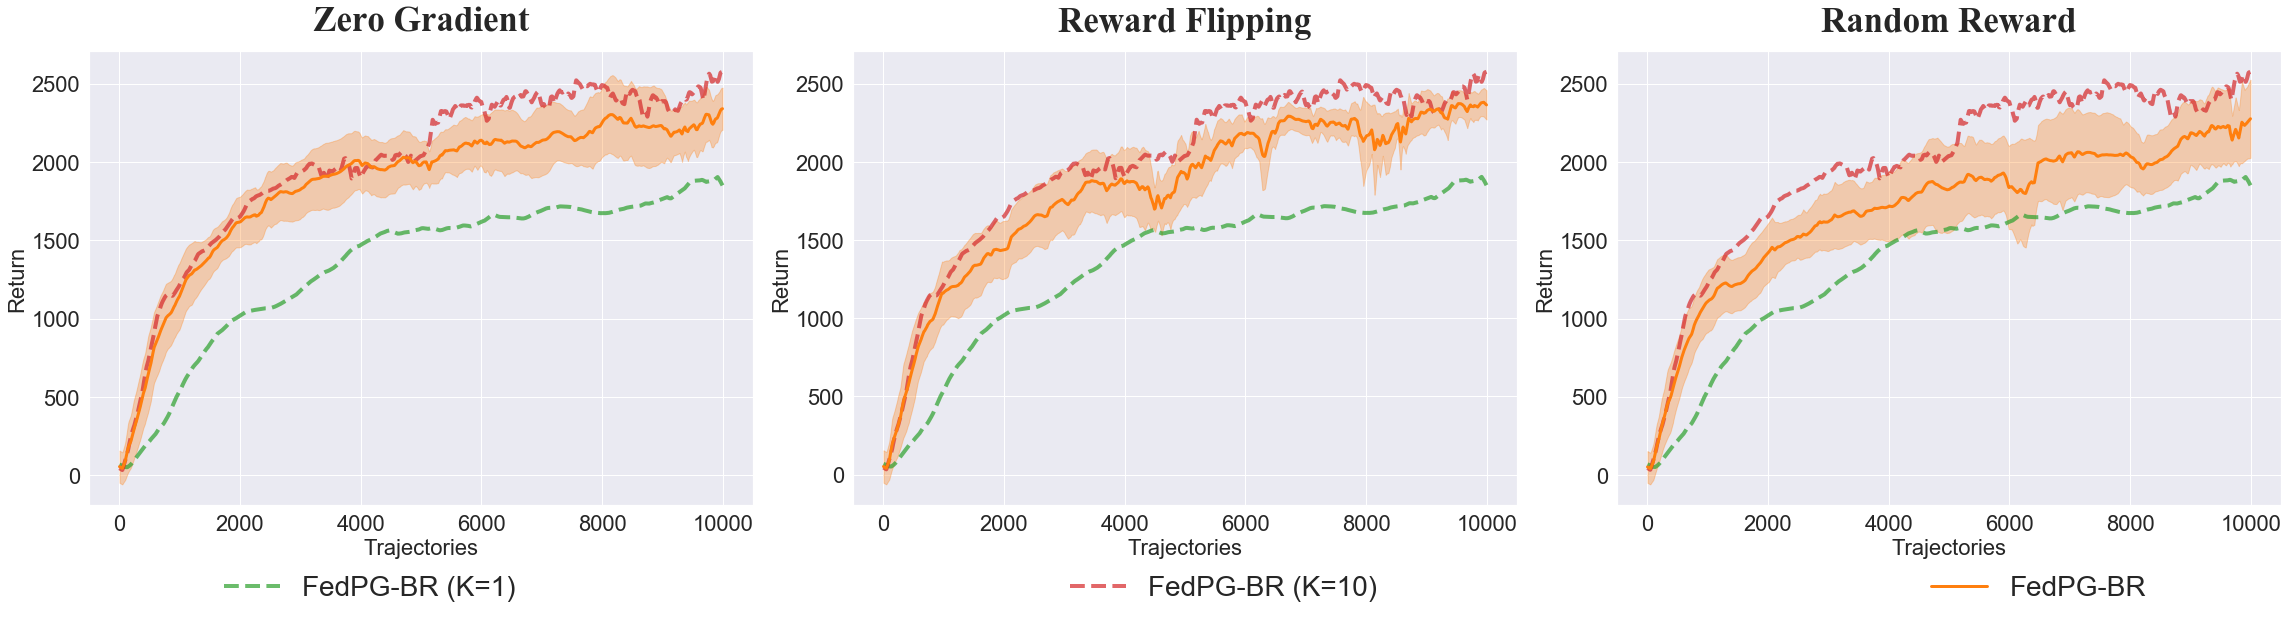

In [72]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 3, figsize=(32,8))
colors =  [u'#2ca02c', u'#d62728', u'#ff7f0e', u'#1f77b4', u'#d62728', u'#8c564b']
#colors = [ u'#1f77b4', u'#2ca02c', u'#d62728', u'#d62728', u'#8c564b']


for plot_id in range(3):

    
    dfw = dfws[plot_id]
    max_trajectories = max_trajectories_ls[plot_id]
    
    runs = dfw["run"].unique()
    runs_ordered = []
    runs_ordered_labels = []
    
    runs_name = []
    for name in runs:
        name = '_'.join((name.split('/')[-1].split('_')[:-1]))
        if not name in runs_name: runs_name.append(name)
    
    for i in range(10):
        for name in runs_name:

            if i == 9 and 'Ours' in name and 'W10B3' in name:
                runs_ordered.append(name)
                runs_ordered_labels.append('FedPG-BR')
            elif i == 1 and 'Ours' in name and ('_W10_' in name or name[-4:] == '_W10'):
                runs_ordered.append(name)
                runs_ordered_labels.append('FedPG-BR (K=10)')
            elif i == 0 and 'Ours' in name and name[-3:] == '_W1':
                runs_ordered.append(name)
                runs_ordered_labels.append('FedPG-BR (K=1)')
           
    print(runs_ordered)
    
    for idx, run_name in enumerate(runs_ordered):
        run_name += '_'
        if 'W10_' in run_name or 'FedPG-BR (K=1)' in runs_ordered_labels[idx]:
            cur_dfw = dfw[dfw.run.str.contains(f'{run_name}')]
            lines = []
            for run_id in range(max_runs):
                steps = cur_dfw[cur_dfw.tag.str.endswith(f'{run_id}')]['step'].to_numpy()
                values = cur_dfw[cur_dfw.tag.str.endswith(f'{run_id}')]['value'].to_numpy()
                lines.append(Rbf(steps, values, function = 'linear')(np.arange(max_trajectories)))
            
            mean = np.mean(lines, axis=0)
            axes[plot_id].plot(mean, label=(f"{runs_ordered_labels[idx]}"), linewidth=4., linestyle = 'dashed', alpha = 0.7, color = colors[idx])
            
            
        else:
            
            cur_dfw = dfw[dfw.run.str.contains(f'{run_name}')]
            lines = []
            print(cur_dfw.tag.unique())
            for run_id in cur_dfw.tag.unique():
                steps = cur_dfw[cur_dfw.tag.str.contains(f'{run_id}')]['step'].to_numpy()
                values = cur_dfw[cur_dfw.tag.str.contains(f'{run_id}')]['value'].to_numpy()
                if steps.size < 200:
                    continue
                else:
#                     print(run_name, run_id)
                    pass
                lines.append(Rbf(steps, values, function = 'linear')(np.arange(max_trajectories)))
            mean = np.mean(lines, axis=0)
            l, h = stats.norm.interval(interval, loc=np.mean(lines, axis = 0), scale=stats.sem(lines, axis = 0))
            axes[plot_id].plot(mean, label=(f"{runs_ordered_labels[idx]}"), linewidth=3, color = colors[idx])
            axes[plot_id].fill_between(range(int(max_trajectories)), l, h, alpha = 0.3, color = colors[idx])    


#         axes[plot_id].xlabel("Trajectories")
#         axes[plot_id].ylabel("Return")
        axes[plot_id].set_title(ENV_NAMES[plot_id], fontsize=35, 
                                pad=20,
                                fontname='Times New Roman')
        axes[plot_id].tick_params(labelsize=22)
        
        axes[plot_id].set_xlabel("Trajectories", fontsize=22)
        axes[plot_id].set_ylabel("Return", fontsize=22)
# ax.set_yticklabels(y_ticks, rotation=0, fontsize=8)
# plt.legend(loc='bottom', 
#            ncol=1, 
#            handlelength=1,
#            mode="expand", 
#            bbox_to_anchor=(1.05, 0, 1,0), borderaxespad=0, prop={'size': 13})
plt.tight_layout(pad=1)


# plt.rcParams["font.family"] = "Times New Roman"

# Shrink current axis's height by 10% on the bottom

length_ = (axes[2].get_position().x1 - axes[0].get_position().x0) / (axes[0].get_position().x1 - axes[0].get_position().x0)


# Put a legend below current axis
plt_lgd = plt.legend(loc='upper left', bbox_to_anchor=(length_ * 0.05, -0.1, length_ * 0.9, 0), bbox_transform=axes[0].transAxes,
         mode = "expand", fancybox=False, shadow=False, ncol=4, fontsize = 28, frameon=False)

plt.savefig('./new3attack_halfcheetah.pdf', format='pdf', dpi=600,
            bbox_extra_artists=(plt_lgd,), bbox_inches='tight')
plt.show()